In [372]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [373]:
rest_lines = np.array([5000.0, 6000.0, 6500.0])   # H‑beta, [O III], H‑alpha-ish placeholders
amps       = np.array([1.0,   0.8,   0.6])        # relative line strengths/

In [374]:
wl = np.linspace(4800, 9000, 7000)

# Guassian:
# w: an array of values. Represents the wavelength.
# w0: represents the center of the peak where Gaussian is tallest.
# amp: the amplitude of the peak
# sigma: a small sigma makes the peak narrow and steep. 
# big sigma makes it wide and smooth
def gaussian(w, w0, amp, sigma=3.0):
    """Simple Gaussian line profile"""
    return amp * np.exp(-(w - w0)**2 / (2.0 * sigma**2))

#Zeros_like returns an array of zeros 
# with the same shape and size as a

# Build rest‑frame template spectrum
template_flux = np.zeros_like(wl)
for w0, amp in zip(rest_lines, amps):
    template_flux += gaussian(wl, w0, amp)
indc =  np.where(template_flux!= 0 )


#print(template_flux[indc])
#print(w0)
#plt.figure(figsize=(10,4))
#plt.plot(wl, template_flux)

The equation looks like this:

$$ f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} $$


$x$ represents the Variable

$\mu$ represents the Mean

$\sigma$ represents standard deviation

$e$ represents the base of the natural log.

properties of Gaussian Distribution:
    
-Symmetric around it's mean

-unimodal (one MODE) (means only one peak)

-Asymptotic

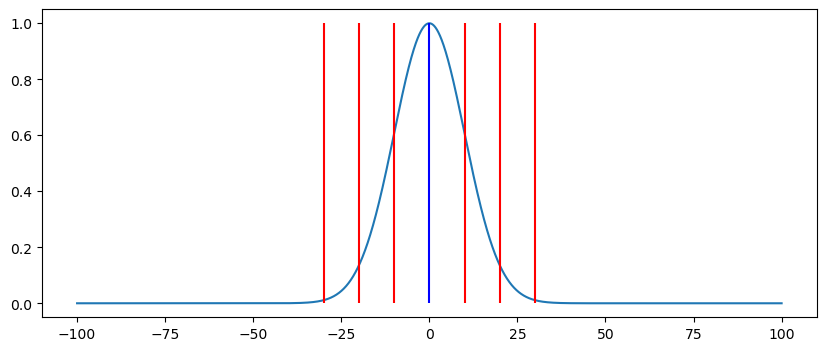

In [375]:

# The X and Y values for the plot below.

gaussianX = np.linspace(-100, 100, 3000)

sd = 10
mean = np.mean(gaussianX)

# Calculating gaussian Y values.
gaussianY = gaussian(mean, gaussianX, 1, sigma= sd)

plt.figure(figsize=(10, 4))
plt.plot(gaussianX, gaussianY)

# Below is the different standard deviation(s) from 1 to 3. The blue line is the mean.
plt.vlines(x=mean, colors=['b'], ymin=0, ymax=1)
for n in range(1, 4):
    plt.vlines(x=mean + n * sd, colors=['r'], ymin=0, ymax=1)
    plt.vlines(x=mean - n * sd, colors=['r'], ymin=0, ymax=1)


plt.show()


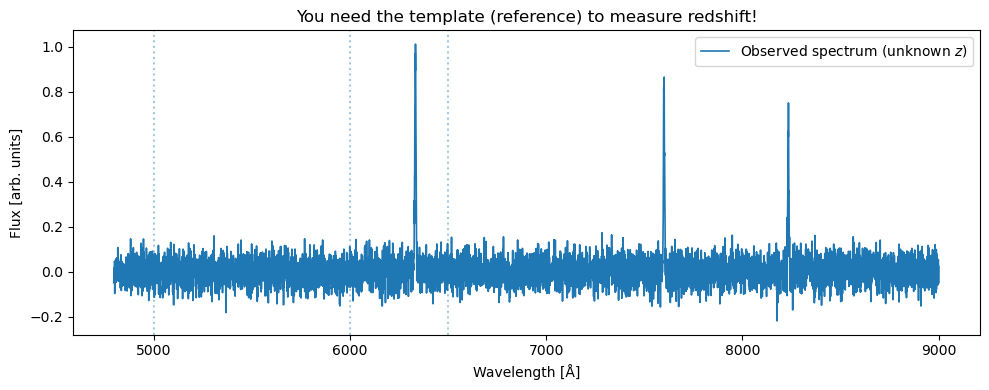

In [376]:
# ------------------------------------
# Apply a redshift to generate “data”
# ------------------------------------
z_true = np.random.uniform(0.0, 0.37)              # the unknown redshift we’ll try to recover
obs_lines = (1.0 + z_true) * rest_lines

observed_flux = np.zeros_like(wl)
for w0, amp in zip(obs_lines, amps):
    observed_flux += gaussian(wl, w0, amp)

# Add a touch of noise so it looks more realistic
rng = np.random.default_rng(42)
observed_flux += 0.05 * rng.normal(size=wl.size)

# ------------------------------------
# Plot: template vs. observed spectrum
# ------------------------------------


plt.figure(figsize=(10, 4))
plt.plot(wl, observed_flux, label=f"Observed spectrum (unknown $z$)", linewidth=1.2)

    #plt.scatter(peaks, wl[peaks])
#plt.plot(wl, template_flux, '--', label="Template (rest‑frame)", linewidth=1.2)

# Mark the *rest* wavelengths (dotted) and observed wavelengths (dash‑dot)
for w_rest, w_obs in zip(rest_lines, obs_lines):
    plt.axvline(w_rest, linestyle=':', alpha=0.4)
    #plt.axvline(w_obs,  linestyle='-.', alpha=0.4)


plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [arb. units]")
plt.title("You need the template (reference) to measure redshift!")
plt.legend()
plt.tight_layout()
plt.show()

The sources I used to learn Cross Correlation:
https://liquidinstruments.com/blog/cross-correlation-and-spectrum-analysis/

https://www.youtube.com/watch?v=cuD-LXic2cE

Cross correlation is the measurement of how well two independent signals resemble each other, a concept known as cross-similarity.
Mathematically, cross-correlation is defined as the intergral of the product of two signals. One signal is given a time delay, T, and the cross-correlation is represented as a function of this time delay.

EX.
When two signals do not have any time overlap, the function is zero. Depending on whether the signals are of similar or opposite amplitudes, the correlation function cano also take on positive and negative values. 

**Signal analysis: Compare a incoming signal to a known template can detect events. 



The equation for Correlation is described as:

$$ r[m] = \sum_{n=0}^{N_1 + N_2 - 2}x_1[n]\space x_2[n+m] $$

Basically, this equation shifts the x_2 array over by 1 (adds it to the last index and moves up the 2nd in line) and r[m] is the sum  of every number in the x_1 array times it's indice in the x_2 array. Where it is the highest value is where it is most correlated (?) (Matches up the best)

The equation for the scipy Correlation:

$$ z[k] = \sum_{l = 0}^{N-1} x_l y_{l-k}^* $$

This matches (each piece) of how well x matches a shifted version of y. also has lag (like the shifted by 1 above) the * means a complex conjugate. pretty cool. Where x and y line up, z[k] will be a high value.

In [377]:
# Setting up the two arrays to show where (or what) x values REALLY match up, to show where they are on the wavelength vs. correlation graph.

# np.argmin() finds the index of the lowest value in the array. wl-rest_lines[at 0, 1, 2]
# returns an array of subtracted values, either pos or neg. 
indc = [np.argmin(np.abs(wl - line)) for line in rest_lines]

# So, If we print out indcies, we will get the closest matching values to each line in rest_lines.
print(f"The closest numbers I found to {rest_lines} in the array wl are {wl[indc]}.")

The closest numbers I found to [5000. 6000. 6500.] in the array wl are [4999.82854694 6000.17145306 6500.04286327].


In [378]:
from scipy.signal import correlate
from scipy.interpolate import interp1d
from scipy.signal import medfilt

In [379]:

# Normalizing the spectrum to focus on shape.
def normalize_spectrum(flux):
    '''
        This function normalizes the flux of my spectrum while also getting rid of the continuum also on the spectrum. (Make the spectrum flat, because most are curved.
        By normalizing it, we make the flux act like a unit vector (a vector w/ one unit)
    '''
    N = len(flux)
    kernel_fraction = 0.01 # 1% of the total length
    kernel_size = int(N * kernel_fraction)
    if N % 2 == 0:
        kernel_size += 1
    kernel_size = max(kernel_size, 3)
    # Traces the curve, or 'shape' of the line...
    continum = medfilt(flux, kernel_size)
    flux_no_continum = flux - continum
    return (flux_no_continum - np.mean(flux_no_continum)) / np.std(flux_no_continum)


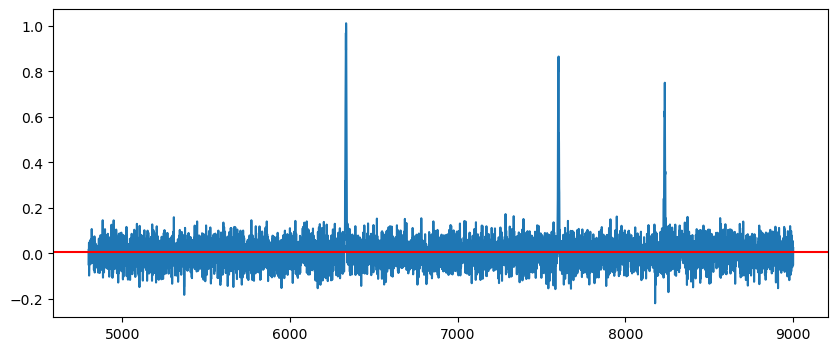

In [380]:
# The 'normalization' will come for later when we have stars that are farther away and have a higher redshift. Although- the POSITIONS and SHAPES of lines are what really
# matter in redshift. 
plt.figure(figsize=(10,4))
plt.plot(wl, observed_flux)
plt.axhline(np.mean(observed_flux), color='r')

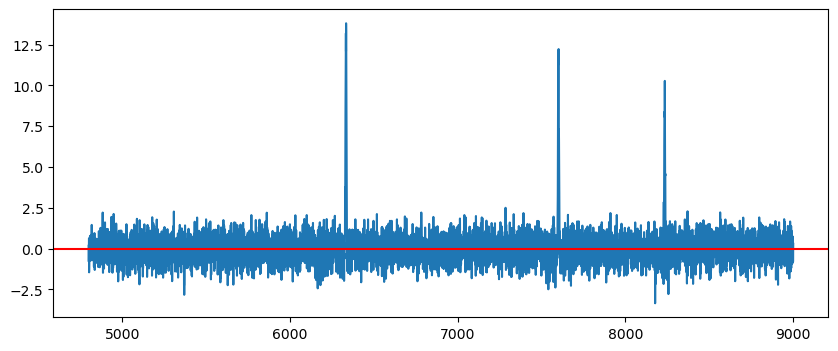

In [381]:
observed_flux_normalized = normalize_spectrum(observed_flux)
plt.figure(figsize=(10, 4))
plt.plot(wl, observed_flux_normalized)
plt.axhline(np.mean(observed_flux_normalized), color='r')

In [382]:
assumed_redshifts = np.linspace(0, 0.37, 9000)

In [383]:
# Talk about this in a moment..

def shift_and_interpolate(wl_obs, wl_temp, flux_temp, z):
    shifted_wl = wl_temp * (1 + z)
    interp_func = interp1d(shifted_wl, flux_temp, bounds_error=False, fill_value=0)
    return interp_func(wl_obs)

In [384]:
def compute_correlate(observed, shifted_temp):
    return np.max(correlate(observed, shifted_temp, mode='same'))

In [385]:
scores = []
normalized_flux = normalize_spectrum(template_flux)
for z in assumed_redshifts:
    shifted_temp = shift_and_interpolate(wl, wl, template_flux, z)
    score = compute_correlate(observed_flux_normalized, shifted_temp)
    scores.append(np.max(score))
best_z = assumed_redshifts[np.argmax(scores)]

0.2666351816868541
0.2667353615375548


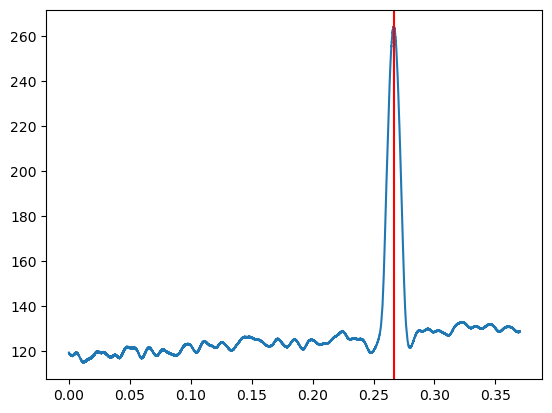

In [386]:
print(best_z)
print(z_true)
plt.plot(assumed_redshifts, scores)
plt.axvline(z_true, color='r')